# New York City Airbnb
Dataset source - [kaggle](kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

## Import modules

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Read data

In [3]:
df = pd.read_csv('data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## EDA

In [6]:
to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df.drop(to_drop, axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


Посмотрим сколько данных отсутствует

In [9]:
df.isna().sum()/df.shape[0]

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

Пропуски в данных есть в столбце reviews_per_month, отсутствует 1/5 данных, убрать строки с пропусками не вариант. Столбец пока оставим.

In [10]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


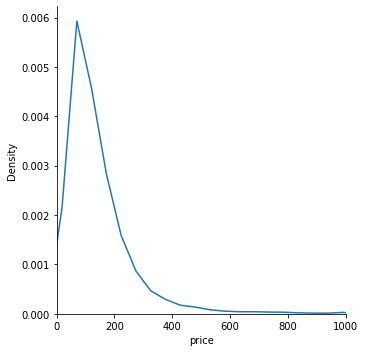

In [26]:
g = sns.displot(data=df, x='price', kind='kde')
g.set(xlim=(0, 1000))

In [44]:
np.quantile(df.price, 0.99)

799.0

In [36]:
df['log_price'] = np.log(df.price.replace({0: 1}))
df.log_price.describe()

count    48895.000000
mean         4.725967
std          0.701737
min          0.000000
25%          4.234107
50%          4.663439
75%          5.164786
max          9.210340
Name: log_price, dtype: float64

Посмотрим на категориальные признаки и распределения цены между разными признаками.

In [14]:
cat_cols = ['room_type', 'neighbourhood_group', 'neighbourhood']
for col in cat_cols:
    cat_unique = df[col].unique()
    print(f'{col} ({len(cat_unique)})\n', df[col].unique())

room_type (3)
 ['Private room' 'Entire home/apt' 'Shared room']
neighbourhood_group (5)
 ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood (221)
 ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkin

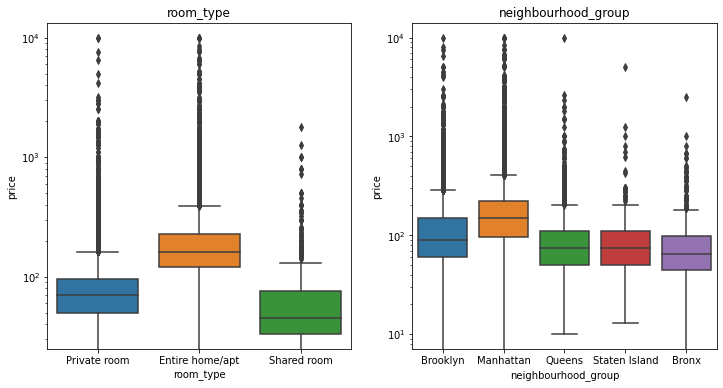

In [64]:
cats = ('room_type', 'neighbourhood_group')
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
for i, cat in enumerate(cats):
    ax[i].set_title(cat)
    sns.boxplot(data=df, x=cat, y='price', ax=ax[i])
    ax[i].set_yscale('log')
plt.show()

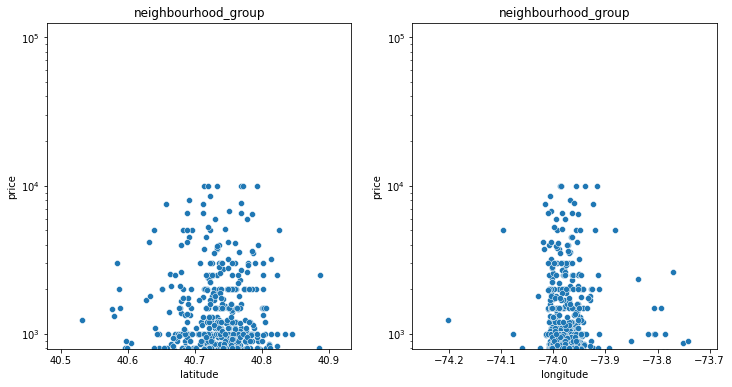

In [67]:
cols = ('latitude', 'longitude')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 6)
for i, col in enumerate(cols):
    ax[i].set_title(cat)
    sns.scatterplot(data=df, x=col, y='price', ax=ax[i])
    ax[i].set_yscale('log')
plt.show()

## Pre-processing

## Modeling